In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as data

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yf

ModuleNotFoundError: ignored

In [ ]:
stock_symbol = 'GAIL.NS'

In [ ]:
#last 5 years data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='5y',interval='1d')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,122.386002,124.185997,119.545372,120.093811,102.120522,4762209
2016-11-21,120.937561,121.921936,118.125061,118.364120,100.649696,5443947
2016-11-22,118.968811,120.571938,114.750053,116.592247,99.143005,7004291
2016-11-23,117.759430,118.139122,114.890678,115.973495,98.616852,5830087
2016-11-24,115.017242,116.057869,112.781303,113.217247,96.273102,5638187
...,...,...,...,...,...,...
2021-11-12,150.149994,150.399994,147.500000,148.000000,148.000000,7011351
2021-11-15,147.850006,149.000000,146.600006,147.050003,147.050003,7233596
2021-11-16,147.149994,148.500000,145.000000,145.600006,145.600006,5789397


In [ ]:
len(data)

1234

In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-04,151.300003,152.000000,151.000000,151.500000,151.500000,889957
2021-11-08,152.500000,153.149994,150.600006,151.899994,151.899994,18312975
2021-11-09,152.000000,152.699997,150.199997,150.649994,150.649994,10971902
2021-11-10,150.649994,153.100006,149.600006,152.100006,152.100006,18919425
2021-11-11,152.000000,152.699997,149.000000,149.500000,149.500000,11239191


<AxesSubplot:xlabel='Date'>

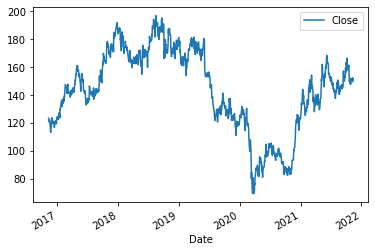

In [ ]:
cls = data[['Close']]
cls.plot()

In [ ]:
ds = cls.values
ds

array([[123.25787354],
       [122.59693909],
       [120.45943451],
       ...,
       [150.6499939 ],
       [152.1000061 ],
       [149.5       ]])

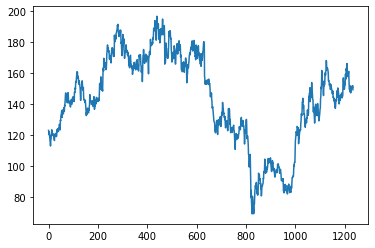

In [ ]:
plt.plot(ds)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [ ]:
len(ds_scaled), len(ds)

(1234, 1234)

In [ ]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size

In [ ]:
train_size,test_size

(863, 371)

In [ ]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [ ]:
len(ds_train),len(ds_test)

(863, 371)

In [ ]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [ ]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [ ]:
X_train.shape,y_train.shape

((762, 100), (762,))

In [ ]:
X_test.shape, y_test.shape

((270, 100), (270,))

In [ ]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [ ]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam',metrics = ['accuracy'])
model.fit(X_train,y_train,epochs=100,batch_size=64)

Epoch 1/100
12/12 [==============================] - 7s 172ms/step - loss: 0.1403 - accuracy: 0.0013
Epoch 2/100
12/12 [==============================] - 2s 181ms/step - loss: 0.0189 - accuracy: 0.0026
Epoch 3/100
12/12 [==============================] - 2s 157ms/step - loss: 0.0110 - accuracy: 0.0026
Epoch 4/100
12/12 [==============================] - 2s 151ms/step - loss: 0.0071 - accuracy: 0.0026
Epoch 5/100
12/12 [==============================] - 2s 142ms/step - loss: 0.0056 - accuracy: 0.0026
Epoch 6/100
12/12 [==============================] - 2s 158ms/step - loss: 0.0046 - accuracy: 0.0026
Epoch 7/100
12/12 [==============================] - 2s 167ms/step - loss: 0.0039 - accuracy: 0.0026
Epoch 8/100
12/12 [==============================] - 2s 175ms/step - loss: 0.0036 - accuracy: 0.0026
Epoch 9/100
12/12 [==============================] - 3s 198ms/step - loss: 0.0035 - accuracy: 0.0026
Epoch 10/100
12/12 [==============================] - 2s 201ms/step - loss: 0.0035 - accura

In [ ]:
model.save('LSTM_modelGAIL4.h5')


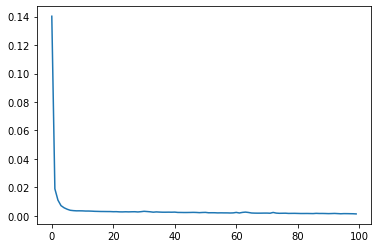

In [ ]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [ ]:
scores = model.evaluate(X_test,y_test)
scores

9/9 [==============================] - 1s 30ms/step - loss: 0.0014 - accuracy: 0.0000e+00


[0.0013759403955191374, 0.0]

In [ ]:

#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


In [ ]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

155.34098694384028

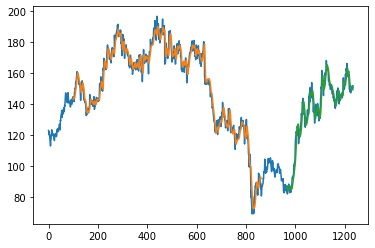

In [ ]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(ds_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(ds_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(ds_scaled)-1, :] = test_predict
# plot baseline and predictions
df2
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
type(trainPredictPlot)
trainPredictPlot
testPredictPlot

array([[         nan],
       [         nan],
       [         nan],
       ...,
       [151.79946899],
       [152.05555725],
       [         nan]])

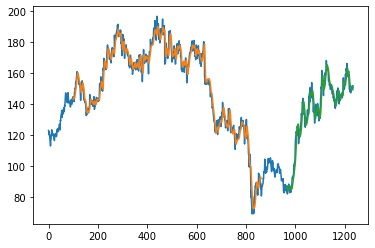

In [ ]:
joined = np.concatenate((trainPredictPlot,testPredictPlot),axis = 1)
joined
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(joined)
plt.show()

In [ ]:
test = np.vstack((train_predict,test_predict))

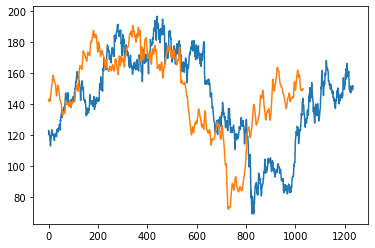

In [ ]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)


In [ ]:
len(ds_test)

378

In [ ]:
#Getting the last 100 days records
fut_inp = ds_test[(len(ds_test)-100):]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

(1, 100)

In [ ]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [ ]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.6402508616447449], [0.6424347758293152], [0.6438952088356018], [0.644714891910553], [0.6449996829032898], [0.6448692083358765], [0.6444482803344727], [0.6438576579093933], [0.6432059407234192], [0.6425830125808716], [0.6420576572418213], [0.6416763067245483], [0.6414638161659241], [0.6414284110069275], [0.6415628790855408], [0.6418498754501343], [0.6422654986381531], [0.642782986164093], [0.6433749198913574], [0.6440156102180481], [0.6446839570999146], [0.6453618407249451], [0.6460363864898682], [0.6466993689537048], [0.6473462581634521], [0.6479755640029907], [0.6485891938209534], [0.6491897106170654], [0.6497812271118164], [0.6503683924674988], [0.6509550213813782], [0.651544988155365], [0.6521414518356323], [0.6527460813522339], [0.6533602476119995], [0.6539846062660217], [0.6546185612678528], [0.6552621126174927], [0.6559137105941772], [0.6565721035003662], [0.6572363376617432], [0.6579053401947021], [0.6585771441459656], [0.6592519879341125], [0.6599283218383789], [0.660605728

In [ ]:
len(ds_scaled)

1235

In [ ]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)

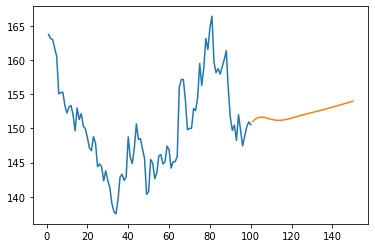

In [ ]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[len(ds_scaled)-100:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [ ]:
ds_new = ds_scaled.tolist()

In [ ]:
len(ds_new)

1235

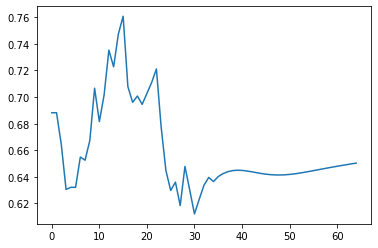

In [ ]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[1200:])

In [ ]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()
len(final_graph)

1265

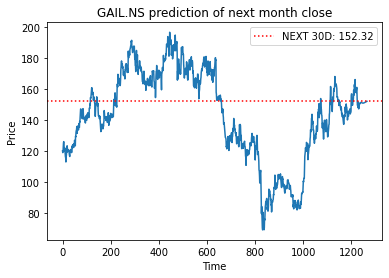

In [ ]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month close".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()